#  Workflow to extract burn severity and climate data for time-lagged moist effects

required modules


In [3]:
import ee 
import geemap
import pandas as pd
import geopandas as gpd
import ltgee
from datetime import date
import ipyleaflet
import rioxarray as rxr
import matplotlib.pyplot as plt

Initialize ee


In [77]:
ee.Initialize(project="ee-jandrewgoldman")

## 1. Process NBAC perimeters 
1. ..
2. ..

Load in fires of interest

In [78]:
shield = ee.FeatureCollection("users/jandrewgoldman/Ontario_Shield_v0")

In [79]:
nbac =ee.FeatureCollection("projects/sat-io/open-datasets/CA_FOREST/NBAC/nbac_1972_2023_20240530").filter(ee.Filter.eq("ADMIN_AREA", "ON")).filter(ee.Filter.gte("YEAR", 1985)) 


Clio the shield feature collection to the nbac feature collection

In [80]:
nbac_shield = nbac.filterBounds(shield.geometry())

Check the column names

In [81]:
#print the all levels of values of a property in the nbac_shield FeatureCollection
def get_unique_values(feature_collection, property_name):
    # Get the unique values of a property in a FeatureCollection
    unique_values = feature_collection.aggregate_array(property_name).getInfo()
    return set(unique_values)

# Get the unique values of the "SPECIES" property  
unique_cause = get_unique_values(nbac_shield, "FIRECAUS")
print("Unique values of the 'FIRE_CAUSE' property in the nbac_shield FeatureCollection:")
for value in unique_cause:
    print(value)

Unique values of the 'FIRE_CAUSE' property in the nbac_shield FeatureCollection:
Natural
Human
Undetermined


remove all human and undetermined
1. check natural strike size
2. check undetermined

In [82]:
nbac_shield_natural = nbac_shield.filter(ee.Filter.eq("FIRECAUS", "Natural"))
nbac_shield_natural_size = nbac_shield_natural.size().getInfo()
print(f"NBAC Ontario Shield FeatureCollection size with natural fire cause: {nbac_shield_natural_size}")

NBAC Ontario Shield FeatureCollection size with natural fire cause: 1394


In [83]:
nbac_shield_undetermined  = nbac_shield.filter(ee.Filter.eq("FIRECAUS", "Undetermined"))
nbac_shield_undetermined_size = nbac_shield_undetermined.size().getInfo()
print(f"NBAC Ontario Shield FeatureCollection size with undetermined fire cause: {nbac_shield_undetermined_size}")

NBAC Ontario Shield FeatureCollection size with undetermined fire cause: 664


Remove all fires greater than 50ha

In [84]:
nbac_shield_nat_gt50 = nbac_shield_natural.filter(ee.Filter.gte("POLY_HA", 50))
nbac_shield_nat_gt50_size = nbac_shield_nat_gt50.size().getInfo()
print(f"NBAC Ontario Shield FeatureCollection size with natural fire cause and greater than 50 hectares: {nbac_shield_nat_gt50_size}")

NBAC Ontario Shield FeatureCollection size with natural fire cause and greater than 50 hectares: 1322


Clean dates by transforming agency dates into YMD

In [85]:
# get AG_SDATE as date object YMD
def convert_to_date(feature):
    ag_sdate = feature.get('AG_SDATE')
    # Convert to ee.Date and format as YYYY-MM-DD
    date_object = ee.Date(ag_sdate)
    formatted_date = date_object.format('YYYY-MM-dd')
    month = date_object.get('month')
    
    # Set both the original date and formatted date as properties
    return feature.set({
        'AG_SDATE_YMD': formatted_date,
        'FIRE_MONTH': month 
    })
nbac_shield_nat_gt50 = nbac_shield_nat_gt50.map(convert_to_date)

for property_name, property_value in nbac_shield_nat_gt50.first().getInfo()['properties'].items():
    print(f"{property_name}: {property_value}")

ADJ_FLAG: true
ADJ_HA: 66.6419217477
ADMIN_AREA: ON
AG_EDATE: 1534575600000
AG_SDATE: 1531897200000
AG_SDATE_YMD: 2018-07-18
BASRC: Agency
FIRECAUS: Natural
FIREMAPM: Undefined
FIREMAPS: Undefined
FIRE_MONTH: 7
GID: 2018_1084
HS_EDATE: 1532156400000
HS_SDATE: 1532156400000
NATPARK: 
NFIREID: 1084
POLY_HA: 72.4925677237
PRESCRIBED: 
VERSION: 20240530
YEAR: 2018


Check to see how many fires are in each year


Number of fires per year:
    Year  Count
16  1986      9
17  1987     19
29  1988     61
8   1989    106
9   1990     33
10  1991     27
11  1992     20
19  1993      9
20  1994     17
21  1995     82
22  1996    106
23  1997      8
31  1998     61
24  1999     25
25  2000      7
26  2001     23
32  2002     52
30  2003     34
3   2005     17
1   2006     80
4   2007      3
5   2008      3
2   2009     20
6   2010     12
7   2011     70
27  2012     53
28  2013     28
34  2014      4
15  2015     32
35  2016      7
12  2017     57
0   2018     64
33  2019     22
13  2020     21
14  2021     74
36  2022      2
18  2023     54


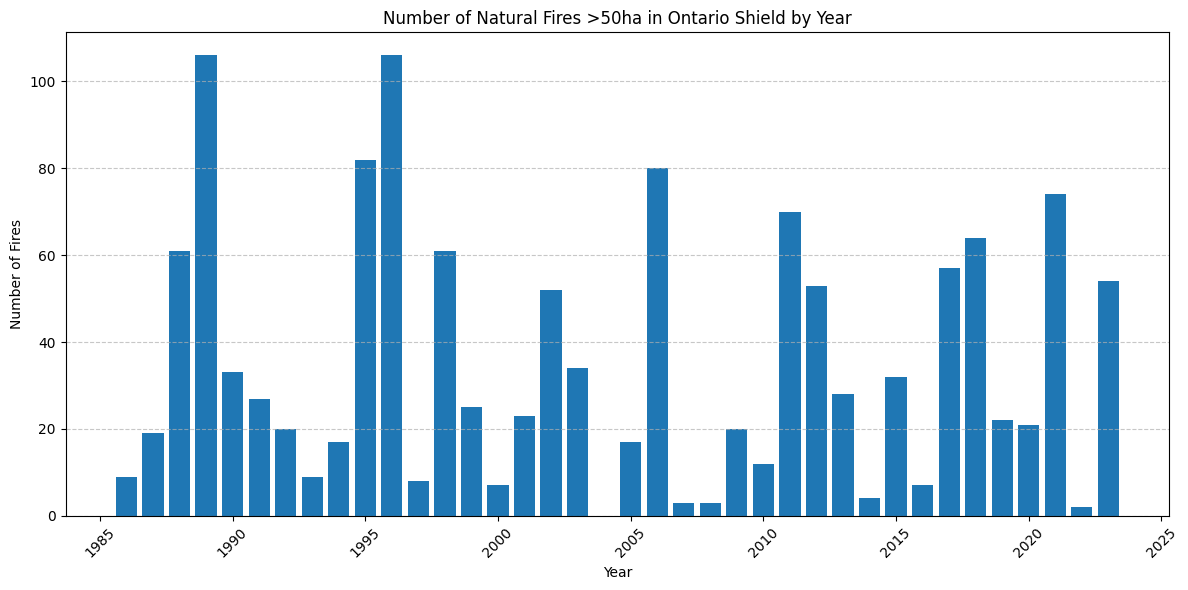

In [86]:
# Get the years as a list
year_list = nbac_shield_nat_gt50.aggregate_array('YEAR').getInfo()

# Count occurrences of each year
year_counts = {}
for year in year_list:
    if year in year_counts:
        year_counts[year] += 1
    else:
        year_counts[year] = 1

# Convert to a dataframe for better visualization
year_df = pd.DataFrame({
    'Year': list(year_counts.keys()),
    'Count': list(year_counts.values())
}).sort_values('Year')

# Display the results
print("Number of fires per year:")
print(year_df)

plt.figure(figsize=(12, 6))
plt.bar(year_df['Year'], year_df['Count'])
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.title('Number of Natural Fires >50ha in Ontario Shield by Year')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

It is common to have date issues in agency data, so filter out all fires with sdate is null

In [87]:


# First filter to keep only fires with non-null AG_SDATE values
nbac_shield_nat_gt50_notnull = nbac_shield_nat_gt50.filter(
    ee.Filter.neq('AG_SDATE', None)
)


# get the number of fires 
nbac_shield_nat_gt50_notnull_size = nbac_shield_nat_gt50_notnull.size().getInfo()
print(f"NBAC Ontario Shield FeatureCollection size with natural fire cause and greater than 50 hectares and non-null AG_SDATE: {nbac_shield_nat_gt50_notnull_size}")



NBAC Ontario Shield FeatureCollection size with natural fire cause and greater than 50 hectares and non-null AG_SDATE: 1320


## 2. Calculate monthly vpd for each fire perimeter 


Script to get monthly vpd from ERA5- Land Monthly Aggregated - ECWMF Climate Reanalysis

**using nbac_shield_nat_gt50** 


1. get monthly vpd for each fire for 12 month's
2. get seasonal vpd for spring, summer, fall
4. get annual for year prior to fire - average over 12 months before
5. calculate climate normal - 1983-2023
    1. Each month
    2. Each Year

Load era5

In [88]:
era5_monthly = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY_AGGR")


In [89]:
def extract_monthly_vpd_for_fires(fire_collection):
    """
    For each fire in the collection, extract monthly VPD values for the 12 months 
    preceding the fire and calculate the spatial average across each fire perimeter.
    
    Args:
        fire_collection: ee.FeatureCollection of fire perimeters
        
    Returns:
        pandas DataFrame with fire IDs and monthly VPD values
    """
    # Function to calculate VPD from era5 data (using temperature and dewpoint)
    def calculate_vpd(image):
        # Get temperature and dewpoint in Kelvin
        t2m = image.select('temperature_2m')
        d2m = image.select('dewpoint_temperature_2m')
        
        # Convert from K to °C
        t2m_c = t2m.subtract(273.15)
        d2m_c = d2m.subtract(273.15)
        
        # Calculate saturation vapor pressure (SVP) using temperature (°C)
        # SVP = 0.611 * exp(17.27 * T / (T + 237.3)) [kPa]
        svp = t2m_c.multiply(17.27).divide(t2m_c.add(237.3)).exp().multiply(0.611)
        
        # Calculate actual vapor pressure (AVP) using dewpoint (°C)
        # AVP = 0.611 * exp(17.27 * Td / (Td + 237.3)) [kPa]
        avp = d2m_c.multiply(17.27).divide(d2m_c.add(237.3)).exp().multiply(0.611)
        
        # Calculate VPD = SVP - AVP [kPa]
        vpd = svp.subtract(avp)
        
        return image.addBands(vpd.rename('vpd'))
    
    # Process each fire
    results = []
    fire_features = fire_collection.getInfo()['features']
    total_fires = len(fire_features)
    skipped_fires = 0
    
    for i, fire in enumerate(fire_features):
        try:
            fire_props = fire['properties']
            fire_id = fire_props.get('NFIREID', 'unknown')
            fire_year = fire_props.get('YEAR')
            fire_month = fire_props.get('FIRE_MONTH')
            
            # Skip fires with missing date information
            if fire_year is None or fire_month is None:
                print(f"Skipping fire {fire_id} due to missing date information (year: {fire_year}, month: {fire_month})")
                skipped_fires += 1
                continue
                
            fire_geometry = ee.Geometry(fire['geometry'])
            
            # Create a feature for this specific fire
            fire_feature = ee.Feature(fire_geometry, fire_props)
            
            # Calculate start date (12 months before fire month)
            start_date = ee.Date.fromYMD(fire_year, fire_month, 1).advance(-12, 'month')
            end_date = ee.Date.fromYMD(fire_year, fire_month, 1)
            
            # Filter ERA5 data for the 12 months before the fire
            era5_filtered = era5_monthly.filterDate(start_date, end_date)
            
            # Add VPD to all images
            era5_with_vpd = era5_filtered.map(calculate_vpd)
            
            # Initialize a dictionary to store results for this fire
            fire_data = {
                'FIREID': fire_id,
                'YEAR': fire_year,
                'MONTH': fire_month,
                'AREA_HA': fire_props.get('POLY_HA', 0)
            }
            
            # Extract VPD values for each of the 12 months before the fire
            for j in range(1, 13):
                # Target date is j months before fire
                target_date = end_date.advance(-j, 'month')
                target_year = target_date.get('year').getInfo()
                target_month = target_date.get('month').getInfo()
                
                # Filter to get the specific month's image
                monthly_image = era5_with_vpd.filter(
                    ee.Filter.calendarRange(target_year, target_year, 'year')
                ).filter(
                    ee.Filter.calendarRange(target_month, target_month, 'month')
                ).first()
                
                # If no image is found, set VPD to NaN
                if monthly_image is None:
                    fire_data[f'vpd_{j}'] = float('nan')
                    continue
                
                # Calculate mean VPD across the fire perimeter
                try:
                    mean_vpd = monthly_image.select('vpd').reduceRegion(
                        reducer=ee.Reducer.mean(),
                        geometry=fire_geometry,
                        scale=9000,  # ERA5-Land resolution is ~9km
                        maxPixels=1e9
                    ).get('vpd').getInfo()
                    
                    # Store the result
                    fire_data[f'vpd_{j}'] = mean_vpd
                except Exception as e:
                    print(f"Error processing fire {fire_id}, month -{j}: {str(e)}")
                    fire_data[f'vpd_{j}'] = float('nan')
            
            results.append(fire_data)
            print(f"Processed fire {fire_id} ({i+1-skipped_fires}/{total_fires-skipped_fires}) ({i+1}/{total_fires} total)")
            
        except Exception as e:
            print(f"Error processing fire at index {i}: {str(e)}")
            skipped_fires += 1
    
    # Create DataFrame from results
    df = pd.DataFrame(results)
    print(f"Completed processing. Total fires: {total_fires}, Processed: {len(results)}, Skipped: {skipped_fires}")
    
    return df

### Run the function to extract VPD values for all fires

1. Create test function
2. test timing for fire size

In [90]:
import time
from datetime import timedelta

def process_fires_with_timing(fire_collection, extract_function, sample_size=None):
    """
    Wrapper function that measures the execution time of extracting data for fires,
    with individual timing for each fire.
    
    Args:
        fire_collection: ee.FeatureCollection of fire perimeters
        extract_function: Function that extracts data from fires (e.g. extract_monthly_vpd_for_fires)
        sample_size: Optional limit on number of fires to process
    
    Returns:
        pandas DataFrame with fire data and timing information
    """
    # Optionally limit the collection size
    if sample_size is not None:
        fire_collection = fire_collection.limit(sample_size)
        print(f"Processing a sample of {sample_size} fires")
    else:
        size = fire_collection.size().getInfo()
        print(f"Processing all {size} fires")
    
    # Start timing the overall process
    overall_start_time = time.time()
    
    # Process each fire individually to time them
    fire_features = fire_collection.getInfo()['features']
    all_results = []
    
    for i, fire in enumerate(fire_features):
        # Start timing this specific fire
        fire_start_time = time.time()
        
        # Create a single-feature collection for this fire
        fire_geom = ee.Geometry(fire['geometry'])
        fire_props = fire['properties']
        fire_feature = ee.Feature(fire_geom, fire_props)
        single_fire_fc = ee.FeatureCollection([fire_feature])
        
        # Process this single fire
        fire_df = extract_function(single_fire_fc)
        
        # End timing for this fire
        fire_end_time = time.time()
        fire_processing_time = fire_end_time - fire_start_time
        
        # Add processing time information
        fire_df['fire_processing_time_seconds'] = fire_processing_time
        
        # Format for progress reporting
        fire_time_str = str(timedelta(seconds=round(fire_processing_time)))
        print(f"Fire {i+1}/{len(fire_features)} (ID: {fire_props['NFIREID']}) processed in {fire_time_str}")
        
        # Append to results
        all_results.append(fire_df)
    
    # Combine all results
    if all_results:
        result_df = pd.concat(all_results, ignore_index=True)
    else:
        result_df = pd.DataFrame()
    
    # Calculate total processing time
    overall_end_time = time.time()
    total_processing_time = overall_end_time - overall_start_time
    
    # Calculate average time per fire
    avg_time_per_fire = total_processing_time / len(result_df) if len(result_df) > 0 else 0
    
    # Format time information nicely
    total_time_str = str(timedelta(seconds=round(total_processing_time)))
    avg_time_str = str(timedelta(seconds=round(avg_time_per_fire)))
    
    # Print timing information
    print(f"Processing completed in {total_time_str}")
    print(f"Average time per fire: {avg_time_str}")
    print(f"Total fires processed: {len(result_df)}")
    
    # Add overall timing information to the DataFrame
    result_df['total_processing_time_seconds'] = total_processing_time
    result_df['avg_processing_time_seconds'] = avg_time_per_fire
    
    return result_df

Run test with 10 fires   

In [ ]:
# Run a test with 10 fires
test_vpd_data = process_fires_with_timing(
    fire_collection=nbac_shield_nat_gt50,
    extract_function=extract_monthly_vpd_for_fires,
    sample_size=10
)

# Display the first few rows
print(test_vpd_data.head())

Run All fires

In [91]:
# Now run VPD extraction on this filtered collection
vpd_data = process_fires_with_timing(
    fire_collection=nbac_shield_nat_gt50_notnull,
    extract_function=extract_monthly_vpd_for_fires, 
    sample_size=None
)



Processing all 1320 fires
Processed fire 1084 (1/1) (1/1 total)
Completed processing. Total fires: 1, Processed: 1, Skipped: 0
Fire 1/1320 (ID: 1084) processed in 0:00:07
Processed fire 2048 (1/1) (1/1 total)
Completed processing. Total fires: 1, Processed: 1, Skipped: 0
Fire 2/1320 (ID: 2048) processed in 0:00:06
Processed fire 682 (1/1) (1/1 total)
Completed processing. Total fires: 1, Processed: 1, Skipped: 0
Fire 3/1320 (ID: 682) processed in 0:00:06
Processed fire 407 (1/1) (1/1 total)
Completed processing. Total fires: 1, Processed: 1, Skipped: 0
Fire 4/1320 (ID: 407) processed in 0:00:06
Processed fire 367 (1/1) (1/1 total)
Completed processing. Total fires: 1, Processed: 1, Skipped: 0
Fire 5/1320 (ID: 367) processed in 0:00:07
Processed fire 1240 (1/1) (1/1 total)
Completed processing. Total fires: 1, Processed: 1, Skipped: 0
Fire 6/1320 (ID: 1240) processed in 0:00:05
Processed fire 1239 (1/1) (1/1 total)
Completed processing. Total fires: 1, Processed: 1, Skipped: 0
Fire 7/13

In [93]:
vpd_data.to_csv('../data/ont_shield_12_month_vpd_data.csv', index=False)

## 3. Climate Normals

In [97]:
def extract_normals_vpd_for_fires(fire_collection):
    """
    For each fire in the collection:
    1. Extract monthly VPD values for the 12 months preceding the fire
    2. Calculate climate normals (1983-2023) for each month at the fire location
    
    Args:
        fire_collection: ee.FeatureCollection of fire perimeters
        
    Returns:
        pandas DataFrame with fire IDs, monthly VPD values, and climate normals
    """
    # Function to calculate VPD from era5 data (using temperature and dewpoint)
    def calculate_vpd(image):
        # Get temperature and dewpoint in Kelvin
        t2m = image.select('temperature_2m')
        d2m = image.select('dewpoint_temperature_2m')
        
        # Convert from K to °C
        t2m_c = t2m.subtract(273.15)
        d2m_c = d2m.subtract(273.15)
        
        # Calculate saturation vapor pressure (SVP) using temperature (°C)
        # SVP = 0.611 * exp(17.27 * T / (T + 237.3)) [kPa]
        svp = t2m_c.multiply(17.27).divide(t2m_c.add(237.3)).exp().multiply(0.611)
        
        # Calculate actual vapor pressure (AVP) using dewpoint (°C)
        # AVP = 0.611 * exp(17.27 * Td / (Td + 237.3)) [kPa]
        avp = d2m_c.multiply(17.27).divide(d2m_c.add(237.3)).exp().multiply(0.611)
        
        # Calculate VPD = SVP - AVP [kPa]
        vpd = svp.subtract(avp)
        
        return image.addBands(vpd.rename('vpd'))
    
    # Process each fire
    results = []
    fire_features = fire_collection.getInfo()['features']
    total_fires = len(fire_features)
    skipped_fires = 0
    
    # Define the climate normal period
    normal_start_date = ee.Date.fromYMD(1983, 1, 1)
    normal_end_date = ee.Date.fromYMD(2023, 12, 31)
    
    # Prepare the ERA5 collection with VPD for the entire period
    era5_full = era5_monthly.filterDate(normal_start_date, normal_end_date).map(calculate_vpd)
    
    for i, fire in enumerate(fire_features):
        try:
            fire_props = fire['properties']
            fire_id = fire_props.get('NFIREID', 'unknown')
            fire_year = fire_props.get('YEAR')
            fire_month = fire_props.get('FIRE_MONTH')
            
            # Skip fires with missing date information
            if fire_year is None or fire_month is None:
                print(f"Skipping fire {fire_id} due to missing date information (year: {fire_year}, month: {fire_month})")
                skipped_fires += 1
                continue
                
            fire_geometry = ee.Geometry(fire['geometry'])
            
            # Create a feature for this specific fire
            fire_feature = ee.Feature(fire_geometry, fire_props)
            
            # Calculate start date (12 months before fire month)
            start_date = ee.Date.fromYMD(fire_year, fire_month, 1).advance(-12, 'month')
            end_date = ee.Date.fromYMD(fire_year, fire_month, 1)
            
            # Filter ERA5 data for the 12 months before the fire
            era5_filtered = era5_monthly.filterDate(start_date, end_date).map(calculate_vpd)
            
            # Initialize a dictionary to store results for this fire
            fire_data = {
                'FIREID': fire_id,
                'YEAR': fire_year,
                'MONTH': fire_month,
                'AREA_HA': fire_props.get('POLY_HA', 0)
            }
            
            # Extract VPD values for each of the 12 months before the fire
            for j in range(1, 13):
                # Target date is j months before fire
                target_date = end_date.advance(-j, 'month')
                target_year = target_date.get('year').getInfo()
                target_month = target_date.get('month').getInfo()
                
                # Filter to get the specific month's image
                monthly_image = era5_filtered.filter(
                    ee.Filter.calendarRange(target_year, target_year, 'year')
                ).filter(
                    ee.Filter.calendarRange(target_month, target_month, 'month')
                ).first()
                
                # If no image is found, set VPD to NaN
                if monthly_image is None:
                    fire_data[f'vpd_{j}'] = float('nan')
                    continue
                
                # Calculate mean VPD across the fire perimeter
                try:
                    mean_vpd = monthly_image.select('vpd').reduceRegion(
                        reducer=ee.Reducer.mean(),
                        geometry=fire_geometry,
                        scale=9000,  # ERA5-Land resolution is ~9km
                        maxPixels=1e9
                    ).get('vpd').getInfo()
                    
                    # Store the result
                    fire_data[f'vpd_{j}'] = mean_vpd
                except Exception as e:
                    print(f"Error processing fire {fire_id}, month -{j}: {str(e)}")
                    fire_data[f'vpd_{j}'] = float('nan')
            
            # Calculate climate normals (one for each calendar month)
            print(f"Calculating climate normals for fire {fire_id}")
            for month in range(1, 13):
                try:
                    # Filter to all images for this calendar month across all years
                    monthly_normal_collection = era5_full.filter(
                        ee.Filter.calendarRange(month, month, 'month')
                    )
                    
                    # Calculate the mean VPD for this month across all years
                    monthly_normal_image = monthly_normal_collection.select('vpd').mean()
                    
                    # Calculate the spatial mean across the fire perimeter
                    normal_vpd = monthly_normal_image.reduceRegion(
                        reducer=ee.Reducer.mean(),
                        geometry=fire_geometry,
                        scale=9000,
                        maxPixels=1e9
                    ).get('vpd').getInfo()
                    
                    # Store the climate normal for this month
                    fire_data[f'normal_vpd_month_{month}'] = normal_vpd
                    
                except Exception as e:
                    print(f"Error calculating normal for fire {fire_id}, month {month}: {str(e)}")
                    fire_data[f'normal_vpd_month_{month}'] = float('nan')
            
            # Calculate annual climate normal (average across all months for all years)
            try:
                annual_normal_image = era5_full.select('vpd').mean()
                annual_normal_vpd = annual_normal_image.reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=fire_geometry,
                    scale=9000,
                    maxPixels=1e9
                ).get('vpd').getInfo()
                
                fire_data['normal_vpd_annual'] = annual_normal_vpd
            except Exception as e:
                print(f"Error calculating annual normal for fire {fire_id}: {str(e)}")
                fire_data['normal_vpd_annual'] = float('nan')
            
            # Calculate seasonal climate normals
            # Spring (MAM), Summer (JJA), Fall (SON), Winter (DJF)
            seasons = {
                'spring': [3, 4, 5],    # March, April, May
                'summer': [6, 7, 8],    # June, July, August
                'fall': [9, 10, 11],    # September, October, November
                'winter': [12, 1, 2]    # December, January, February
            }
            
            for season_name, season_months in seasons.items():
                try:
                    # Filter to all images for this season across all years
                    season_collection = era5_full.filter(
                        ee.Filter.calendarRange(min(season_months), max(season_months), 'month')
                    )
                    
                    # Calculate the mean VPD for this season across all years
                    season_normal_image = season_collection.select('vpd').mean()
                    
                    # Calculate the spatial mean across the fire perimeter
                    season_normal_vpd = season_normal_image.reduceRegion(
                        reducer=ee.Reducer.mean(),
                        geometry=fire_geometry,
                        scale=9000,
                        maxPixels=1e9
                    ).get('vpd').getInfo()
                    
                    # Store the seasonal climate normal
                    fire_data[f'normal_vpd_{season_name}'] = season_normal_vpd
                    
                except Exception as e:
                    print(f"Error calculating {season_name} normal for fire {fire_id}: {str(e)}")
                    fire_data[f'normal_vpd_{season_name}'] = float('nan')
            
            results.append(fire_data)
            print(f"Processed fire {fire_id} ({i+1-skipped_fires}/{total_fires-skipped_fires}) ({i+1}/{total_fires} total)")
            
        except Exception as e:
            print(f"Error processing fire at index {i}: {str(e)}")
            skipped_fires += 1
    
    # Create DataFrame from results
    df = pd.DataFrame(results)
    print(f"Completed processing. Total fires: {total_fires}, Processed: {len(results)}, Skipped: {skipped_fires}")
    
    return df

Test function for climate normals

In [98]:
# Test with a small sample first
climate_normal_test = process_fires_with_timing(
    fire_collection=nbac_shield_nat_gt50_notnull,
    extract_function=extract_normals_vpd_for_fires,
    sample_size=5
)

# Check that the climate normal columns were created
print("Climate normal columns in results:")
normal_columns = [col for col in climate_normal_test.columns if 'normal_vpd' in col]
for col in normal_columns:
    print(f"  - {col}")


Processing a sample of 5 fires
Calculating climate normals for fire 1084
Processed fire 1084 (1/1) (1/1 total)
Completed processing. Total fires: 1, Processed: 1, Skipped: 0
Fire 1/5 (ID: 1084) processed in 0:00:36
Calculating climate normals for fire 2048
Processed fire 2048 (1/1) (1/1 total)
Completed processing. Total fires: 1, Processed: 1, Skipped: 0
Fire 2/5 (ID: 2048) processed in 0:00:35
Calculating climate normals for fire 682
Processed fire 682 (1/1) (1/1 total)
Completed processing. Total fires: 1, Processed: 1, Skipped: 0
Fire 3/5 (ID: 682) processed in 0:00:31
Calculating climate normals for fire 407
Processed fire 407 (1/1) (1/1 total)
Completed processing. Total fires: 1, Processed: 1, Skipped: 0
Fire 4/5 (ID: 407) processed in 0:00:32
Calculating climate normals for fire 367
Processed fire 367 (1/1) (1/1 total)
Completed processing. Total fires: 1, Processed: 1, Skipped: 0
Fire 5/5 (ID: 367) processed in 0:00:38
Processing completed in 0:02:53
Average time per fire: 0:0

In [99]:
climate_normal_test

,FIREID,YEAR,MONTH,AREA_HA,vpd_1,vpd_2,vpd_3,vpd_4,vpd_5,vpd_6,...,normal_vpd_month_11,normal_vpd_month_12,normal_vpd_annual,normal_vpd_spring,normal_vpd_summer,normal_vpd_fall,normal_vpd_winter,fire_processing_time_seconds,total_processing_time_seconds,avg_processing_time_seconds
0,1084,2018,7,72.492568,0.669658,0.545711,0.175584,0.110644,0.080693,0.060050,...,0.134508,0.075196,0.316732,0.291716,0.649325,0.257070,0.316732,36.486261,172.708056,34.541611
1,2048,2018,7,696.593685,0.665035,0.556806,0.177242,0.110646,0.083038,0.061934,...,0.133585,0.074974,0.315537,0.291801,0.643493,0.257376,0.315537,34.879273,172.708056,34.541611
2,682,2006,9,418.791459,0.778667,0.846925,0.769764,0.362467,0.274363,0.097601,...,0.128175,0.059313,0.303674,0.239504,0.651562,0.268339,0.303674,30.822429,172.708056,34.541611
3,407,2009,6,1171.499040,0.246373,0.159087,0.076971,0.041950,0.026677,0.024798,...,0.078647,0.037075,0.258012,0.199259,0.595703,0.200447,0.258012,31.993257,172.708056,34.541611
4,367,2009,6,900.941585,0.225806,0.141971,0.067387,0.038388,0.025544,0.024034,...,0.072371,0.035212,0.241191,0.176195,0.564316,0.190196,0.241191,37.689707,172.708056,34.541611
